In [67]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

import folium
from folium.plugins import HeatMap, HeatMapWithTime

In [104]:

data = pd.read_csv('../../socialdata2024/files/Police_Department_Incident_Reports__Historical_2003_to_May_2018_20240210.csv')


In [105]:
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data = data.loc[data['Datetime'] < '2018-01-01 00:00:00']
data['Hour'] = data['Datetime'].apply(lambda x: x.hour)

In [106]:
markers = np.array([
    [37.80029, -122.41018, 'North Beach'],
    [37.79417, -122.40694, 'Chinatown'],
    [37.77722, -122.41111, 'South of Market'],
    [37.78806, -122.4075, 'Union Square'],
    [37.7825, -122.4108, 'Theatre District'],
    [37.76083, -122.435, 'Castro District'],
    [37.803, -122.436, 'Marina District'],
    [37.791190, -122.420828, 'Polk Street'],
    [37.76, -122.42, 'Mission'],
])

polk_street = [(37.806217, -122.423863), (37.776601, -122.417903)]

In [107]:
k = 2
indices_of_data_within_square = []
indices_of_data_within_radius = []

for marker in markers: 
    within_square = (float(marker[0]) - 0.001 * k < data.Y) & (float(marker[0]) + 0.001 * k > data.Y) & (float(marker[1]) - 0.001 * k < data.X) & (float(marker[1]) + 0.001 * k > data.X)
    indices_of_data_within_square += list(within_square.loc[within_square].index)

    # now make it within radius 
    within_radius = (data.Y - float(marker[0]))**2 + (data.X - float(marker[1]))**2 < (0.001 * k)**2
    indices_of_data_within_radius += list(within_radius.loc[within_radius].index)
    


In [108]:
indices_of_data_within_square = pd.Series(indices_of_data_within_square).drop_duplicates()
indices_of_data_within_radius = pd.Series(indices_of_data_within_radius).drop_duplicates()


In [141]:
data_party = data.loc[data['Category'].isin(['DRUG/NARCOTIC', 'LIQUOR LAWS', 'VANDALISM', 'PROSTITUTION', 'DRUNKENNESS', 'DRIVING UNDER THE INFLUENCE', 'LOITERING', 'GAMBLING'])]
#data_party = data_party.loc[(data["Datetime"] >= '2017-01-01 00:00:00') & (data["Datetime"] < '2018-01-01 00:00:00')]
data_party_geo = data_party[data_party.index.isin(indices_of_data_within_radius)][['Y', 'X']]

In [142]:
data_party[data_party.index.isin(indices_of_data_within_radius)].reset_index(drop=True).to_csv('party_data.csv')

In [143]:
df = data_party[data_party.index.isin(indices_of_data_within_radius)].reset_index(drop=True)

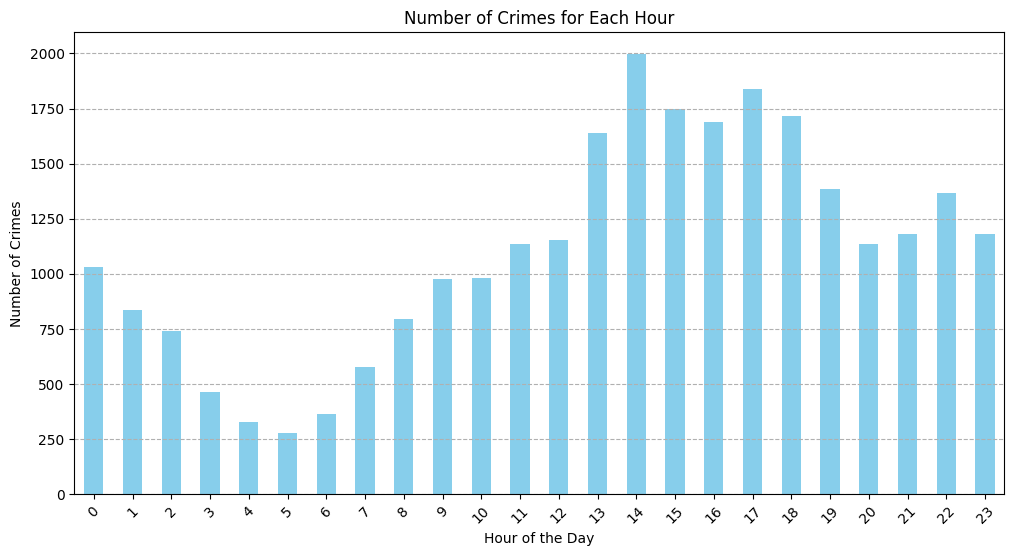

In [144]:
import matplotlib.pyplot as plt

# Count the number of crimes for each hour
crime_counts_by_hour = df['Hour'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
crime_counts_by_hour.plot(kind='bar', color='skyblue')
plt.title('Number of Crimes for Each Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()


In [145]:
# Redefine the day categories to be 'Weekday' and 'Weekend'
# Weekend is considered to be from Friday 12:00 to Sunday 12:00
df['DayType'] = 'Weekday'


In [146]:
df.loc[ (df['DayOfWeek'] == 'Friday') & (df['Hour'] >= 12), 'DayType'] = 'Weekend'
df.loc[df['DayOfWeek'] == 'Saturday', 'DayType'] = 'Weekend'
df.loc[(df['DayOfWeek'] =='Sunday') & (df['Hour'] < 12), 'DayType'] = 'Weekend'

In [147]:
common_crime_types = df['Category'].value_counts().head(10)
top_crime_types = common_crime_types.index.tolist()

In [148]:
def plot_polar_bar_chart(data, title, ax):
    # Convert data to list and append the first value to the end to close the loop
    values = data.tolist() + [data.iloc[0]]
    # There are 24 hours, so we divide the circle into 24 segments
    angles = np.linspace(0, 2 * np.pi, len(values), endpoint=False)
    
    # Polar bar chart
    ax.bar(angles, values, color='skyblue', alpha=0.7, width=angles[1]-angles[0]*0.85)
    
    # Set the labels (0, 1, ..., 23, 0) to make the plot circular
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels((data.index).astype(str), rotation=45)
    
    ax.set_title(title)

In [149]:

# Find the maximum count for each crime type for a consistent scale within each row
max_counts_per_crime = {}
for crime_type in top_crime_types:
    max_count = 0
    for day_type in day_types:
        filtered_data = df[(df['Category'] == crime_type) & (df['DayType'] == day_type)]
        hour_counts = filtered_data['Hour'].value_counts()
        if hour_counts.max() > max_count:
                    # weekend lasts 2 days and weekdays last 5 days
        
            max_count = hour_counts.max()
            if day_type == 'Weekend':
                max_count /= 2
            else: 
                max_count /= 5
    max_counts_per_crime[crime_type] = max_count

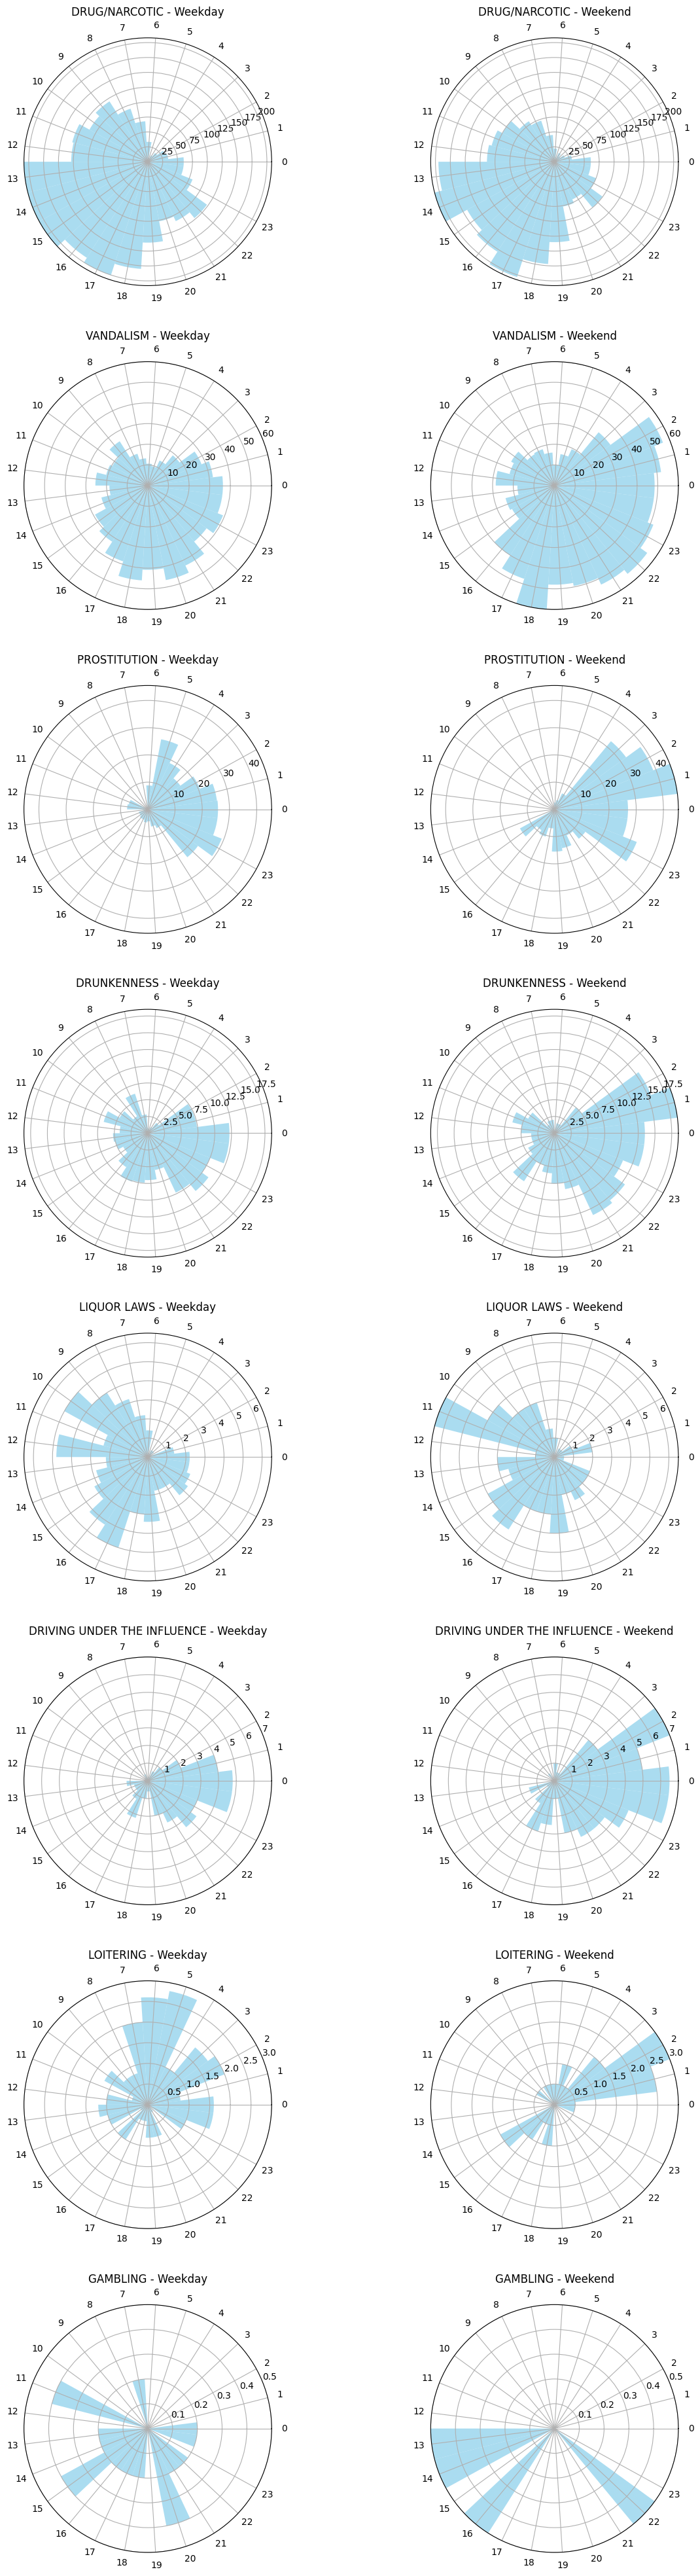

In [150]:

# Prepare the figure
fig, axs = plt.subplots(len(top_crime_types), 2, figsize=(14, 5*len(top_crime_types)), subplot_kw=dict(polar=True))

day_types = ['Weekday', 'Weekend']

for i, crime_type in enumerate(top_crime_types):
    for j, day_type in enumerate(day_types):
        # Filter data for each crime type and day type
        filtered_data = df[(df['Category'] == crime_type) & (df['DayType'] == day_type)]
        
        # Count occurrences by hour
        hour_counts = filtered_data['Hour'].value_counts().sort_index()
        
        # weekend lasts 2 days and weekdays last 5 days
        if day_type == 'Weekend':
            hour_counts /= 2
        else: 
            hour_counts /= 5
        
        # Ensure all hours are represented
        all_hours = pd.Series(index=np.arange(24), data=0)  # Placeholder for all hours
        hour_counts = all_hours.add(hour_counts, fill_value=0)
        
        ax = axs[i, j]
        # consistent scale for all plots
        ax.set_ylim(0, max_counts_per_crime[crime_type])
        plot_polar_bar_chart(hour_counts, f"{crime_type} - {day_type}", ax)

plt.tight_layout(pad=3.0)
plt.show()
